In [1]:
import json
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, ttest_rel
from collections import Counter
from nltk.tokenize.casual import TweetTokenizer
from nltk import MWETokenizer, pos_tag, RegexpParser
tokenizer = TweetTokenizer()
from nltk.corpus import stopwords
from conllu import parse, parse_tree
from nltk.stem.snowball import EnglishStemmer as Stemmer
stemmer = Stemmer()

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt

import re
import string
stop = stopwords.words('english') + list(string.punctuation) + ['’', '...', '”', '“', '—', '…']

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
# helper functions
def get_words_by_pos_tag(t, pos_tag):
    """ Returns a list of lists where each list contains words that forms a pos_tag in the syntax tree
    """
    try:
        t.label()
    except AttributeError:
        # get the word
        if t[1] == pos_tag:
            return [t[0]]
        else:
            return []
    else:
        # Now we know that t.node is defined
        res = []
        if t.label() == pos_tag:
            res.append(get_list_of_words_in_tree(t))
        else:
            for child in t:
                res += get_words_by_pos_tag(child, pos_tag)
        return res
            
def get_list_of_words_in_tree(t):
    """ Returns a list that contains all words that syntax tree
    """
    try:
        t.label()
    except AttributeError:
        # get the word
        return [t[0]]
    else:
        res = []
        for child in t:
            res += get_list_of_words_in_tree(child)
        return res

# Section 1: Data Preparation

## Read Tweets and Meta Data

In [3]:
tweet_json_file = "./data/all_tweets_with_meta.json"
with open(tweet_json_file, 'r') as f:
    long_tweets = json.load(f)

In [4]:
tweets = []
for tweet in long_tweets:
    tweets.append({
        'created_at': tweet['created_at'], 
        'text': tweet['text'],
        'in_reply_to_user_id': tweet['in_reply_to_screen_name'],
        'user': tweet['user']['screen_name'].lower(), 
        'favorite_count': tweet['favorite_count'],
        'retweet_count': tweet['retweet_count'],
        'mentioned_url': [u["expanded_url"] for u in tweet["entities"]["urls"]] if tweet["entities"]["urls"] else [],
        'photo_url': [m["media_url"] for m in tweet["entities"]["media"] if m["type"] == "photo"] if "media" in tweet["entities"] else []})

## Read Candidate Relations

In [5]:
candidate_jsonlist_file = "./2014_us_gubernatorial_election_candidates_with_twitter.jsonlist"
candidates = []
with open(candidate_jsonlist_file, 'r') as f:
    for line in f:
        candidates.append(json.loads(line))

In [6]:
state_to_candidates = {}
for c in candidates:
    state = c['state']
    if state not in state_to_candidates:
        state_to_candidates[state] = set()
    state_to_candidates[state].add((c['name'].lower(), c['twitter'].lower()))

### Build Opponent Relationship

In [7]:
opponents = {}

# candidate relationship
for c in candidates:
    # key in by twitter handle
    t = c['twitter'].lower()
    if not t:
        continue
    if t not in opponents:
        opponents[t] = set()
        
    state_wide_opponents = state_to_candidates[c['state']]
    for name, twitter in state_wide_opponents:
        if twitter == t:
            continue
        if not twitter:
            continue
        
        opponents[t].add("@" + twitter.lower())
        for name_component in name.split():
            if name_component:
                opponents[t].add(name_component.lower())
        opponents[t].add(name)

## Attack Tweets

In [8]:
attacking = []
for tweet in tweets:
    user = tweet['user']
    oppo = opponents[user]
    text = tweet['text']
    
    tokenzied = tokenizer.tokenize(text)
    tokenzied = [token.lower() for token in tokenzied]
    attacking.append(any([o in tokenzied for o in oppo]) or "opponent" in tokenzied)
    
print("{0:.2f}% of tweets are attack tweets".format(100 * attacking.count(True) / len(attacking)))

11.62% of tweets are attack tweets


In [9]:
# get index of these attack tweets
attacking_index = [i for i, a in enumerate(attacking) if a]

In [10]:
for ai in attacking_index[10:20]:
    tweet = tweets[ai]
    user = tweet['user']
    oppo = opponents[user]
    text = tweet['text']
    
    print(text)
    print(oppo)
    print()

CRIST VS. SCOTT—FLORIDA CATFIGHT ROUND 3. COMEDY OR TRAGEDY? 

Last night’s “debate” on CNN would have been... http://t.co/OISjlchZvY
{'adrian', '@glennburkett4fl', 'charlie crist', 'glenn', 'rick', 'glenn burkett', 'adrian wyllie', 'charlie', 'burkett', 'rick scott', 'scott', 'wyllie', '@scottforflorida', '@charliecrist', '@wyllieforgov', 'crist'}

I have many other common sense positions that the Mr. Mead could adopt. How about removing his censor of science standards. #HelptheGov
{'matt', 'matt mead', 'mead', '@meadforgovernor'}

.@WSJ: Prosecutors are looking at whether Cuomo directed the Moreland Commission not to refer cases for prosecution http://t.co/dPsNk5k3ul
{'andrew', '@nygovcuomo', 'cuomo', '@howiehawkins', 'andrew cuomo', 'michael mcdermott', 'michael', 'howie hawkins', 'hawkins', '@votemcdermott', 'mcdermott', 'howie'}

The election for Texas Governor is in 3 months. Don't let Obama &amp; Wendy Davis hijack Texas. Donate $20.14 --&gt; http://t.co/yEFbdeEmZF
{'@kathieglas

## Merge Dataset

### + Attacking

In [11]:
for tweet, is_attack in zip(tweets, attacking):
    tweet['is_attack'] = is_attack

### + Geography

In [12]:
candidate_to_state = {}
for c in candidates:
    t = c['twitter'].lower()
    if t:
        candidate_to_state[t] = c['state']
        
for tweet in tweets:
    tweet['state'] = candidate_to_state[tweet['user']]

### + Party

In [13]:
candidate_to_party = {}
for c in candidates:
    t = c['twitter'].lower()
    if t:
        candidate_to_party[t] = c['party']
        
for tweet in tweets:
    tweet['party'] = candidate_to_party[tweet['user']]

### + Incumbency

In [14]:
candidate_to_incumbency = {}
for c in candidates:
    t = c['twitter'].lower()
    if t:
        candidate_to_incumbency[t] = c['incumbency']
        
for tweet in tweets:
    tweet['incumbency'] = candidate_to_incumbency[tweet['user']]

### + Competitiveness
Needs to + States first

In [15]:
with open("./competitiveness.jsonlist", 'r') as f:
    state_to_competitiveness = json.load(f)

for tweet in tweets:
    state = tweet['state']
    tweet['competitiveness'] = state_to_competitiveness[state]

### + Affect

In [16]:
affect_map_file = "./library/NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
affect_map = {}
with open(affect_map_file, 'r') as f:
    for line in f:
        token, affect, score = line.strip().split("\t")
        score = int(score)
        token = stemmer.stem(token)
        if token not in affect_map:
            affect_map[token] = {}
        affect_map[token][affect] = score

In [17]:
affects = set(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust'])

for tweet in tweets:
    text = tweet['text']
    tokens = tokenizer.tokenize(text)
    tokens = [token.lower() for token in tokens]
    tokens = set([stemmer.stem(token) for token in tokens if token not in stop])
    tweet['affects'] = {a: 0 for a in affects}
    
    for t in tokens:
        if t in affect_map:
            token_affects = affect_map[t]
            for affect, score in token_affects.items():
                tweet['affects'][affect] += score

## Filter Out Penn Tweets

Pennsylvania seems like an outlier which has an extremely high percentage of attack tweets. By excluding it, we see results that conform to previous literture.

Now it seems okay... there was an issue with candidate name and such. Just in case this comes back later, this code block is kept here for now.

In [18]:
# tweets = [tweet for tweet in tweets if tweet['state'] != "Pennsylvania"]

# Section 2: Analysis and Methods

## Attack By States

In [19]:
state_to_attack_count = Counter()
state_to_total_tweets = Counter()

for tweet in tweets:
    is_attack = tweet['is_attack']
    state = tweet['state']
    
    state_to_total_tweets[state] += 1
    
    if is_attack:
        state_to_attack_count[state] += 1

states = list(state_to_total_tweets.keys())        
rates = [state_to_attack_count[state] / state_to_total_tweets[state] for state in states]

df_attack_rate_by_state = pd.DataFrame(index=states, data=rates, columns=["attack_rate"])

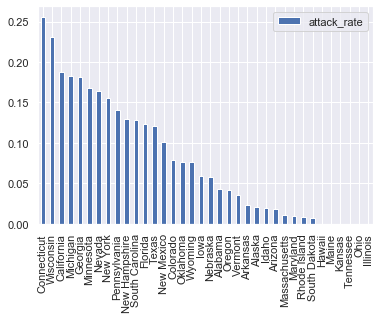

In [20]:
df_attack_rate_by_state.sort_values("attack_rate", ascending=False).plot.bar()

## Attack By Party

In [21]:
party_to_attack_count = Counter()
party_to_total_tweets = Counter()

for tweet in tweets:
    is_attack = tweet['is_attack']
    party = tweet['party']
    
    party_to_total_tweets[party] += 1
    
    if is_attack:
        party_to_attack_count[party] += 1

parties = list(party_to_total_tweets.keys())        
rates = [party_to_attack_count[party] / party_to_total_tweets[party] for party in parties]

df_attack_rate_by_party = pd.DataFrame(index=parties, data=rates, columns=["attack_rate"])

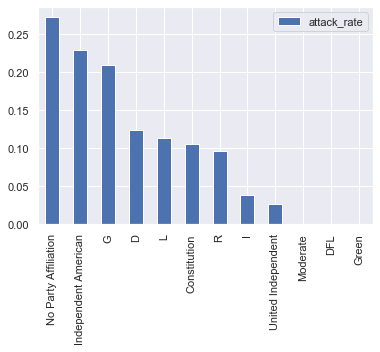

In [22]:
df_attack_rate_by_party.sort_values("attack_rate", ascending=False).plot.bar()

## Attack By Incumbency

In [23]:
incumbency_to_attack_count = Counter()
incumbency_to_total_tweets = Counter()

for tweet in tweets:
    is_attack = tweet['is_attack']
    incumbency = tweet['incumbency']
    
    incumbency_to_total_tweets[incumbency] += 1
    
    if is_attack:
        incumbency_to_attack_count[incumbency] += 1

incumbencies = list(incumbency_to_total_tweets.keys())        
rates = [incumbency_to_attack_count[incumbency] / incumbency_to_total_tweets[incumbency] for incumbency in incumbencies]

readable_i_mapping = {True: "Incumbent", 
                      False: "Challenger"}

readable_i = [readable_i_mapping[i] for i in incumbencies]
df_attack_rate_by_incumbency = pd.DataFrame(index=readable_i, data=rates, columns=["attack_rate"])

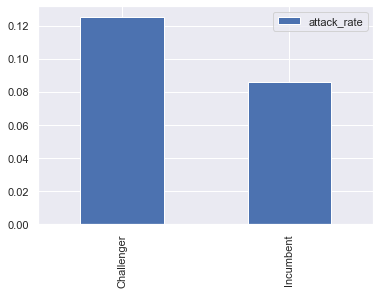

In [24]:
df_attack_rate_by_incumbency.sort_values("attack_rate", ascending=False).plot.bar()

## Attack By Competitiveness

In [25]:
competitiveness_to_attack_count = Counter()
competitiveness_to_total_tweets = Counter()

for tweet in tweets:
    is_attack = tweet['is_attack']
    competitiveness = tweet['competitiveness']
    
    competitiveness_to_total_tweets[competitiveness] += 1
    
    if is_attack:
        competitiveness_to_attack_count[competitiveness] += 1

competitivenesses = list(competitiveness_to_total_tweets.keys())        
rates = [competitiveness_to_attack_count[competitiveness] / competitiveness_to_total_tweets[competitiveness] for competitiveness in competitivenesses]

readable_c_mapping = {True: "Competitive", 
                      False: "Non-competitive"}

readable_c = [readable_c_mapping[c] for c in competitivenesses]

df_attack_rate_by_competitiveness = pd.DataFrame(index=readable_c, data=rates, columns=["attack_rate"])

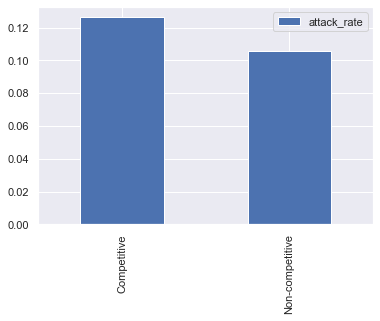

In [26]:
df_attack_rate_by_competitiveness.sort_values("attack_rate", ascending=False).plot.bar()

## Attack by Joint (Competiveness, Incumbency)

In [27]:
ci_to_attack_count = Counter()
ci_to_total_tweets = Counter()

for tweet in tweets:
    is_attack = tweet['is_attack']
    competitiveness = tweet['competitiveness']
    incumbency = tweet['incumbency']
    
    ci_to_total_tweets[(competitiveness, incumbency)] += 1
    
    if is_attack:
        ci_to_attack_count[(competitiveness, incumbency)] += 1

cies = list(ci_to_total_tweets.keys())        
rates = [ci_to_attack_count[ci] / ci_to_total_tweets[ci] for ci in cies]

readable_ci_mapping = {(True, True): ("Competitive", "Incumbent"), 
                      (True, False): ("Competitive", "Challenger"),
                      (False, True): ("Non-competitive", "Incumbent"),
                      (False, False): ("Non-competitive", "Challenger")}

readable_ci = [readable_ci_mapping[ci] for ci in cies]
df_attack_rate_by_ci = pd.DataFrame(index=readable_ci, data=rates, columns=["attack_rate"])

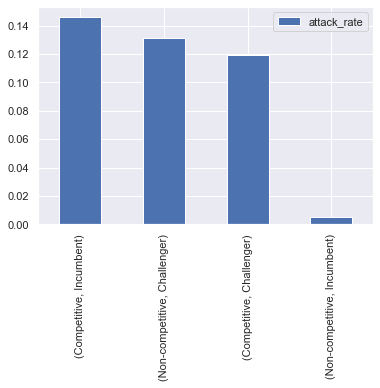

In [28]:
df_attack_rate_by_ci.sort_values("attack_rate", ascending=False).plot.bar()

## Do Attacks Get More Attention?

### Favorites

In [29]:
favs_nonattack = [tweet['favorite_count'] for tweet in tweets if not tweet["is_attack"]]
favs_attack = [tweet['favorite_count'] for tweet in tweets if tweet["is_attack"]]

In [30]:
print("(Nonattack tweets) mean: {0:.2f}, st dev: {0:.2f}".format(np.mean(favs_nonattack), np.std(favs_nonattack)))

(Nonattack tweets) mean: 6.89, st dev: 6.89


In [31]:
print("(Atk tweets) mean: {0:.2f}, st dev: {0:.2f}".format(np.mean(favs_attack), np.std(favs_attack)))

(Atk tweets) mean: 8.31, st dev: 8.31


In [32]:
ttest_ind(favs_nonattack, favs_attack, equal_var=False)

Ttest_indResult(statistic=-3.342685870738775, pvalue=0.0008371099822576556)

### Retweets

In [33]:
retweets_nonattack = [tweet['retweet_count'] for tweet in tweets if not tweet["is_attack"]]
retweets_attack = [tweet['retweet_count'] for tweet in tweets if tweet["is_attack"]]

In [34]:
print("(Nonattack tweets) mean: {0:.2f}, st dev: {0:.2f}".format(np.mean(retweets_nonattack), np.std(retweets_nonattack)))

(Nonattack tweets) mean: 8.41, st dev: 8.41


In [35]:
print("(Atk tweets) mean: {0:.2f}, st dev: {0:.2f}".format(np.mean(retweets_attack), np.std(retweets_attack)))

(Atk tweets) mean: 14.34, st dev: 14.34


In [36]:
ttest_ind(retweets_nonattack, retweets_attack, equal_var=False)

Ttest_indResult(statistic=-10.195795554151957, pvalue=4.250236877139859e-24)

From the t-test results, attack tweets do get more favorites and retweets. 

**TODO: How to account for different candidates who might have different popularities on Twitter.**

## Distiguishing Ad Hominem Attacks

### Vocab

In [37]:
vocab = Counter()
for tweet_index in attacking_index:
    tweet = tweets[tweet_index]
    text = tweet['text']
    tokens = tokenizer.tokenize(text)
    tokens = [token.lower() for token in tokens]
    tokens = [stemmer.stem(token) for token in tokens if token not in stop]
    vocab.update(tokens)
counts = [c for _, c in vocab.most_common()]

In [38]:
print("Vacab counts: max is {} and min is {}".format(max(counts), min(counts)))

Vacab counts: max is 479 and min is 1


In [39]:
print("Vocab counts: {}th percentile is: {}".format(80, np.percentile(counts, 80)))

Vocab counts: 80th percentile is: 4.0


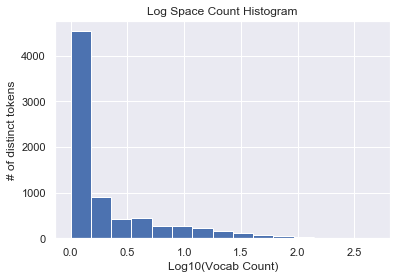

In [40]:
plt.hist(np.log10(counts), bins = 15)
plt.title("Log Space Count Histogram")
plt.ylabel("# of distinct tokens")
plt.xlabel("Log10(Vocab Count)")
plt.show()

In [41]:
%%script false --no-raise-error

# export words for coding
token_coding_file = "./token_coding_init.csv"
with open(token_coding_file, 'w') as f:
    f.write("count,token,is_policy\n")
    for token, count in vocab.most_common():
        f.write("{}, {}, {}\n".format(count, token, ""))

In [42]:
token_coding_finished_file = "./token_coding.csv"
c = 0
policy_tokens = set()
with open(token_coding_finished_file, 'r') as f:
    f.readline()
    for line in f:
        coded_line = line.strip().split(",")[:-1]
        if coded_line[-1] == "":
            break
        if coded_line[-1] == "1":
            policy_tokens.add(coded_line[1].strip())
        c += 1
print("{} tokens labeled".format(c))
print("{} policy tokens".format(len(policy_tokens)))

1000 tokens labeled
36 policy tokens


In [43]:
is_policies_token_based = []
for tweet_index in attacking_index:
    tweet = tweets[tweet_index]
    text = tweet['text']
    tokens = tokenizer.tokenize(text)
    tokens = [token.lower() for token in tokens]
    tokens = [stemmer.stem(token) for token in tokens if token not in stop]
    is_policy = any([token in policy_tokens for token in tokens])
    is_policies_token_based.append(is_policy)

In [44]:
pc = sum(is_policies_token_based)
tc = len(is_policies_token_based)
print("Total policy tweets: {} out of {} ({:.2f}%)".format(pc, tc, pc / tc * 100))

Total policy tweets: 1084 out of 3378 (32.09%)


In [45]:
for ai, p in zip(attacking_index, is_policies_token_based):
    text = tweets[ai]['text']
    if p:
        print(text)
        print()

Summing up the race:

—11K jobs created in Sept under Malloy-Wyman
—@TomFoleyCT won’t talk about his outsourcing of jobs

That’s it. #ctgov

.@TomFoleyCT is refusing to release his state tax returns because they "must be extraordinarily damaging.” http://t.co/ZZwNrDZLFa #ctgov

Q6 Obamacare. Abbott: wants block grants from fed gov &amp; more $ on womens care. Davis:Texas sends too much $ to DC... http://t.co/1AcaHdzFtr

They've had enough of Rick Scott's education cuts in Tallahassee! Next stop: Jacksonville! #RestoreTheCuts http://t.co/Bpvcn4umKq

Further proof that @MaryFallin and @JanetBarresi ("Fal-esi") have worked hand in hand to fail public education: https://t.co/AxVTykZUSs

“@TomFoleyCT doesn’t understand what we’re doing on education.” #ctdebate #CTProgress

.@CharlieCrist had the job once, and he couldn’t even show up to work. https://t.co/HH0xxoi00r #sayfie

ALWAYS THE SAME STORY—PEOPLE’S SUFFERING!

Mr. Khavari,
Since Rick Scott did not opt to expand Medicaid under the... 

In [46]:
# append references
for ai, ip in zip(attacking_index, is_policies_token_based):
    tweets[ai]["is_policy"] = ip

for tweet in tweets:
    if "is_policy" not in tweet:
        tweet["is_policy"] = False

### References

In [47]:
# gather all pronoun tags
pos_tag_to_include = set(["PRP", "PRP$"])

prp_set = set()

startswithany = lambda x, y: any([x.startswith(yy) for yy in y])

for ai in attacking_index:
    tweet = tweets[ai]
    text = tweet["text"]
    tokens = tokenizer.tokenize(text)
    tokens = [token for token in tokens if not startswithany(token, set(["#", "@", "http"]))]
    pos_tags = [pos for _, pos in pos_tag(tokens)]
    prp_set.update([token.lower() for token, pos in zip(tokens, pos_tags) if (pos in pos_tag_to_include)])

In [48]:
# these references are obtained through NLTK code above
us_ref = set([
 'me',
 'my',
 'myself',
 'our',
 'us',
 'we'
])

them_ref = set([
 'he',
 "he's",
 'her',
 'him',
 'himself',
 'his',
 'our',
 'she',
 'their',
 'them',
 'themselves',
 'they'
])

In [49]:
is_contrast = []

for ai in attacking_index:
    tweet = tweets[ai]
    text = tweet["text"]
    tokens = tokenizer.tokenize(text)
    tokens = [token for token in tokens if not startswithany(token, set(["#", "@", "http"]))]
    pos_tags = [pos for _, pos in pos_tag(tokens)]
    tokens = [token.lower() for token, pos in zip(tokens, pos_tags) if (pos in pos_tag_to_include)]
    is_us = any([us_token in tokens for us_token in us_ref])
#     is_them = any([us_token in tokens for us_token in them_ref])
    is_contrast.append(is_us)

In [50]:
cc = sum(is_contrast)
tc = len(is_contrast)
print("Total contrast tweets: {} out of {} ({:.2f}%)".format(cc, tc, cc / tc * 100))

Total contrast tweets: 552 out of 3378 (16.34%)


In [51]:
for ai, c in zip(attacking_index, is_contrast):
    text = tweets[ai]['text']
    if c:
        print(text)
        print()

My record of support for sexual assault survivors speaks for itself. @GregAbbott_TX can't keep his story straight: http://t.co/oc47w0rdyb

“@ScottWalker: We're telling ppl what we're for... Our opponent is telling voters what she's against.” I'm tell voters your both clueless.

Right now if we follow the Pete Ricketts plan we go to paying the full cost. #TeamHassebrook #NeGov

.@MikelSevere @karrie1 @RickettsForGov @OWHnews @OWHBottomLine we at doing what we can to get it broadcast.  Stay tuned! #punintended #negov

“@TomFoleyCT doesn’t understand what we’re doing on education.” #ctdebate #CTProgress

One county, one school district? My opponent gets an "F" on his plans for education. http://t.co/flTpFQ3yFg #negov

@dario_rivero @Varneyco @FoxBusiness thank you. Maybe we should just crown King Jerry, the coddled prince?

4 yrs of @NathanDeal has left us w/ high unemp. &amp; low-performing schools - Michael Coles, Chair, Campaign Committee https://t.co/q7bFppW3ww

My campaign will take 

In [52]:
# append references
for ai, ic in zip(attacking_index, is_contrast):
    tweets[ai]["is_contrast"] = ic

for tweet in tweets:
    if "is_contrast" not in tweet:
        tweet["is_contrast"] = False

### Language: Attack Affect

In [53]:
%%script false --no-raise-error

df_affect_tweets = pd.DataFrame(columns = ['is_attack'] + [affect for affect in affects])
for tweet in tqdm_notebook(tweets):
    tweet_affects = tweet['affects']
    is_attack = tweet['is_attack']
    row = {a : s for a, s in tweet_affects.items()}
    row['is_attack'] = is_attack
    df_affect_tweets = df_affect_tweets.append(row, ignore_index = True)
    
# change data type to get correlations
df_affect_tweets['is_attack'] = df_affect_tweets['is_attack'].astype('int')
for a in affects:
    df_affect_tweets[a] = df_affect_tweets[a].astype('int')
    
df_affect_tweets.corr(method = "kendall")[['is_attack']]

## Export

In [55]:
export_json_file = "./all_tweets_with_coding.json"
with open(export_json_file, 'w') as f:
    json.dump(tweets, f)

## Experimental Section

In [54]:
# comment this line to run
assert False

AssertionError: 

### Media & Links

In [ ]:
any("Jimmie" in tweet["text"] for tweet in tweets)

In [ ]:
attack_tweet_texts = [tweets[ai]["text"] for ai in attacking_index]
attack_tweet_mentioned_url = [tweets[ai]["mentioned_url"] for ai in attacking_index]
attack_tweet_photo_url = [tweets[ai]["photo_url"] for ai in attacking_index]
oppo_per_attack_tweet = [opponents[tweets[ai]["user"]] for ai in attacking_index]

In [ ]:
attack_tweet_texts_tmp = []
for text, oppos in zip(attack_tweet_texts, oppo_per_attack_tweet):
    for oppo in sorted(oppos, key=lambda x : -len(x)):
        replacing = re.compile(oppo, re.IGNORECASE)
        text = replacing.sub("Jimmie", text)
    
    replacing = re.compile("opponent", re.IGNORECASE)
    text = replacing.sub("Jimmie", text)
    
    replacing = re.compile("opponents", re.IGNORECASE)
    text = replacing.sub("Jimmie", text)
    
    attack_tweet_texts_tmp.append(text)

attack_tweet_texts = attack_tweet_texts_tmp

In [ ]:
all_photos = set()
all_urls = set()

for i in range(len(attack_tweet_texts)):
    t = attack_tweet_texts[i]
    u = attack_tweet_mentioned_url[i]
    p = attack_tweet_photo_url[i]
    
    all_urls.update(u)
    all_photos.update(p)
    
print("Total URL: {}; total photos: {}".format(len(all_urls), len(all_photos)))

In [ ]:
no_media = [t for t, m, u in zip(attack_tweet_texts, attack_tweet_mentioned_url, attack_tweet_photo_url) if not m and not u]

print("No media tweets: {}; media tweets: {}".format(len(no_media), len(attack_tweet_texts) - len(no_media)))

### Dependency Parsing

In [ ]:
tweet_predict_file = "./library/TweeboParser/test.txt.predict"

In [ ]:
conll = []
with open(tweet_predict_file, 'r') as f:
    for line in f:
        conll.append(line)

conll = "".join(conll)
conll = parse(conll)[0]

In [ ]:
conll.filter(upostag='^')

In [ ]:
conll.filter(upostag='N')

In [ ]:
conll.filter(upostag='@')

In [ ]:
with open("attack_tweets.csv", 'w') as f:
    f.write("tweet" + "\n")
    for t in attack_tweet_texts:
        t = t.replace("\n", " ")
        t = t.replace("\t", " ")
        t = t.replace("\"", "'")
        t = t.replace("&amp;", "&")
        f.write("\"" + t + "\"\n")

In [ ]:
for i, token in enumerate(conll, 1):
    if len(token["form"]) >= len("Democrat"):
        tabs = "\t\t\t"
    else:
        tabs = "\t\t\t\t"
    print("{}\t{}{}{}\t{}".format(i, token["form"], tabs, token["upostag"], token["head"]))

### Topic Model (LDA)

In [ ]:
topic_model_input_file = "./all_attack_tweet_texts.txt"
pos_tag_to_include = set(["NN", "NNS", "JJ"])

startswithany = lambda x, y: any([x.startswith(yy) for yy in y])

with open(topic_model_input_file, 'w') as f:
    for ai in attacking_index:
        tweet = tweets[ai]
        text = tweet["text"]
        tokens = tokenizer.tokenize(text)
        tokens = [token for token in tokens if not startswithany(token, set(["#", "@", "http"]))]
        pos_tags = [pos for _, pos in pos_tag(tokens)]
        text = " ".join([stemmer.stem(token) for token, pos in zip(tokens, pos_tags) if (pos in pos_tag_to_include)])
        text = text.replace("\n", " ")
        f.write(text)
        f.write("\n")

In [ ]:
%%bash

# mallet path
MALLET="../../ARK/library/mallet-2.0.8/bin/mallet"
# file path
INPUT="./all_attack_tweet_texts.txt"
MALLET_FILE="./all_attack_tweet_texts.txt.mallet"
OUTPUT_TOPIC_KEYS="./all_attack_tweet_texts_topic_keys.txt"
OUTPUT_DOC_TOPICS="./all_attack_tweet_texts_doc_topics.txt"

#hyperparams
NUM_ITER=5000
NUM_TOPICS=50

# convert format
$MALLET import-file --input $INPUT --output $MALLET_FILE --keep-sequence --remove-stopwords
# train
$MALLET train-topics --input $MALLET_FILE --num-topics $NUM_TOPICS --num-top-words 10 --output-topic-keys $OUTPUT_TOPIC_KEYS --output-doc-topics $OUTPUT_DOC_TOPICS --num-iterations $NUM_ITER --optimize-interval 10

rm $MALLET_FILE

In [ ]:
topic_keys_file = "./all_attack_tweet_texts_topic_keys.txt"
topic_keys_coding_file = "./all_attack_tweet_texts_topic_keys_coding_init.csv"

topic_keys = []

with open(topic_keys_file, 'r') as f:
    for line in f:
        tid, _, keys = line.strip().split("\t")
        topic_keys.append((tid, keys))
        
with open(topic_keys_coding_file, 'w') as f:
    f.write("{}, {}, {}\n".format("tid", "keys", "is_policy"))
    for tk in topic_keys:
        tid, keys = tk
        f.write("{}, {}, {}\n".format(tid, keys, ""))

In [ ]:
topic_keys_coding_file = "./data/all_attack_tweet_texts_topic_keys_coding.csv"
doc_topics_file = "./all_attack_tweet_texts_doc_topics.txt"

argmax = lambda x: max(enumerate(x), key = lambda y: y[1])[0]

topic_codings = {}
with open(topic_keys_coding_file, 'r') as f:
    f.readline()
    for line in f:
        tid, _, is_policy = line.strip().split(",")
        topic_codings[int(tid)] = int(is_policy) == 1
        
is_policies = []
tid_assignments = []
with open(doc_topics_file, 'r') as f:
    for line in f:
        tid_assignment = argmax([float(x) for x in line.strip().split("\t")[2:]])
        is_policy = topic_codings[tid_assignment]
        is_policies.append(is_policy)
        tid_assignments.append(tid_assignment)

In [ ]:
for ai, p, t in zip(attacking_index, is_policies, tid_assignments):
    text = tweets[ai]['text']
    if not p:
        print(text)
        print(t)
        print()